## Final Project Submission

Please fill out:
* Student name: Juico Bowley
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carassco


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd

import scipy.stats as scs 
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold

from IPython.core.display import HTML
from IPython.display import IFrame
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsFunctions as sf

In [2]:
df = pd.read_csv("../data/kc_house_data.csv")
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
# check for null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [4]:
# inspect waterfront
df.waterfront.value_counts(dropna=False)
# this series represents houses that have a view of the waterfront with a value of 1.0 and houses without a view of a waterfront with a 0.0
# I may fill NaNs with 0s. I'll assume that if it's a water front property they'd surely list it as such and not leave it blank

0.0    19075
NaN     2376
1.0      146
Name: waterfront, dtype: int64

In [5]:
# inspect view
df.view.value_counts(dropna=False)
# data description "states * **view** - Has been viewed" but I don't really know what that means. I'll probably just drop this column or these rows

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
NaN       63
Name: view, dtype: int64

In [6]:
# inspect yr_renovated
df.yr_renovated.value_counts(dropna=False)
# if value is 0.0 I'm assuming that the house has not yet been renovated, so I may translate NaN values here to 0.0 or drop the NaN rows entirely

0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

In [7]:
# show value counts for each feature to inspect highest frequency values and potentially uncover abonormalities
for col in df.columns:
    print(col, '\n', df[col].value_counts(dropna=False).head(), '\n\n')

'''
- seems like there are multiples of id's which seems like an issue
- may need to transform date with pd date type
- having 3/4 and 1/4 bathrooms seemed weird but based on the data description it's a ratio of bathrooms/bedrooms
- condition = overall condition of the house - I assume quality?
- grade = based on king county grading system
- hidden NaN placeholder in sqft_basement - may drop those rows
- lat/long are given, would be cool to map these out for a nice viz
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors
'''

id 
 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64 


date 
 6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64 


price 
 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
Name: price, dtype: int64 


bedrooms 
 3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64 


bathrooms 
 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
Name: bathrooms, dtype: int64 


sqft_living 
 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64 


sqft_lot 
 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: int64 


floors 
 1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
Name: floors, dtype: int64 


waterfront 
 0.0    19075
NaN     2376
1.0      146
Name: waterfront, dtype: int64 


view 
 0.0    19422
2.0      957
3.0      508
1

"\n- seems like there are multiples of id's which seems like an issue\n- may need to transform date with pd date type\n- having 3/4 and 1/4 bathrooms seemed weird but based on the data description it's a ratio of bathrooms/bedrooms\n- condition = overall condition of the house - I assume quality?\n- grade = based on king county grading system\n- hidden NaN placeholder in sqft_basement - may drop those rows\n- lat/long are given, would be cool to map these out for a nice viz\n* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors\n* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors\n"

## Resolve Null Values 

In [8]:
# translate NaN values for waterfront with 0.0 under the assumption that they don't have a waterfront view
df.waterfront = df.waterfront.fillna(0.0)
df.waterfront.value_counts(dropna=False)

0.0    21451
1.0      146
Name: waterfront, dtype: int64

In [9]:
# traslate NaN values for year renovated with 0.0 under the assumption that the house has not yet been renovated
df.yr_renovated = df.yr_renovated.fillna(0.0)
df.yr_renovated.isna().sum()

0

In [10]:
# translating the 63 NaN values in view with the mode of 0.0
df.view = df.view.fillna(0.0)
df.view.isna().sum()

0

In [11]:
#  translating values listed as '?' in sqft_basement with the mode of '0.0' under the assumption the house doesn't have a basement and that houses with a basement would be listed as such
df.sqft_basement = df.sqft_basement.replace('?','0.0')
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
2120.0        1
2730.0        1
2240.0        1
248.0         1
274.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [12]:
df.sqft_basement = df.sqft_basement.astype('float64')
df.sqft_basement[0]

0.0

In [13]:
# creating a ratio of bedrooms to bathrooms in order to reduce multicollinearity
df['bed_to_bath'] = df['bedrooms'] / df['bathrooms']
df.bed_to_bath

0        3.000000
1        1.333333
2        2.000000
3        1.333333
4        1.500000
           ...   
21592    1.200000
21593    1.600000
21594    2.666667
21595    1.200000
21596    2.666667
Name: bed_to_bath, Length: 21597, dtype: float64

In [14]:
# encoding basement with 0.0 and 1.0 to represent houses with and without basements in order to reduce multicollinearity
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1.0 if x > 0 else 0.0)
df.has_basement.value_counts(dropna=False)

0.0    13280
1.0     8317
Name: has_basement, dtype: int64

In [15]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'bed_to_bath',
       'has_basement'],
      dtype='object')

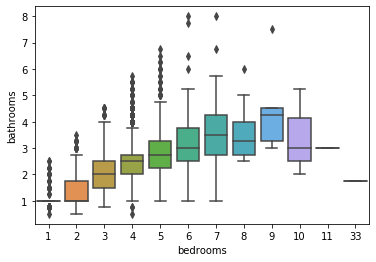

In [16]:
# closer inspection on critical features
sns.boxplot(x='bedrooms',y='bathrooms',data=df);
# seems as if the bedroom with 33 rooms is an outlier

In [17]:
df.loc[df.bedrooms == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_to_bath,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,18.857143,1.0


In [18]:
display(HTML('<a href="https://www.google.com/maps/@47.606331,-122.3320088,216m/data=!3m1!1e3?hl=en-US">It looks like the number of 33 Bedrooms accidentally came from the number of units the 5th & Madison condo complex.</a>'))

In [19]:
df = df[df.bedrooms != 33]
df.bedrooms.max()

11

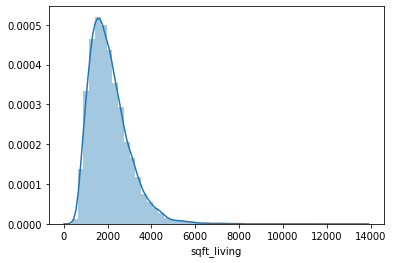

In [20]:
sns.distplot(df.sqft_living);

In [21]:
df.sqft_lot.max()
df.loc[df.sqft_lot > 999999]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_to_bath,has_basement
1717,1020069017,3/27/2015,700000.0,4,1.00,1300,1651359,1.0,0.0,3.0,...,0.0,1920,0.0,98022,47.2313,-122.023,2560,425581,4.000000,0.0
7640,2623069031,5/21/2014,542500.0,5,3.25,3010,1074218,1.5,0.0,0.0,...,1000.0,1931,0.0,98027,47.4564,-122.004,2450,68825,1.538462,1.0
7762,2323089009,1/19/2015,855000.0,4,3.50,4030,1024068,2.0,0.0,0.0,...,0.0,2006,0.0,98045,47.4619,-121.744,1830,11700,1.142857,0.0
17305,3326079016,5/4/2015,190000.0,2,1.00,710,1164794,1.0,0.0,0.0,...,0.0,1915,0.0,98014,47.6888,-121.909,1680,16730,2.000000,0.0


In [22]:
display(HTML('<a href="https://www.google.com/maps/place/41301+236th+Ave+SE,+Enumclaw,+WA+98022/@47.2312996,-122.0301264,17z/data=!3m1!4b1!4m5!3m4!1s0x5490f3d49bb946ff:0xaf376f5a1eb45695!8m2!3d47.2312996!4d-122.0279377">First</a>'))
display(HTML('<a href="https://www.google.com/maps/place/16311+252nd+Ave+SE,+Issaquah,+WA+98027/data=!4m2!3m1!1s0x549064071a007647:0x6252b43e26c4723a?sa=X&ved=2ahUKEwjuvvvb6Z3sAhUEAp0JHXcKAkkQ8gEwAHoECAsQAQ">Second</a>'))
display(HTML('<a href="https://www.google.com/maps/place/44635+SE+151st+Pl,+North+Bend,+WA+98045/@47.4628047,-121.7462238,17z/data=!3m1!4b1!4m5!3m4!1s0x54907de5eb4c72af:0x35fe03dc7906a824!8m2!3d47.4628047!4d-121.7440351">Third</a>'))
display(HTML('<a href="https://www.google.com/maps/place/10219+Kelly+Rd+NE,+Carnation,+WA+98014/@47.6894167,-121.9112012,16.65z/data=!4m5!3m4!1s0x549075bc7ec101ed:0x84879373a023bb88!8m2!3d47.688255!4d-121.9080129">Fourth</a>'))
print('It seems that these large outliers are simply in large rural areas which explain the large lot size')

It seems that these large outliers are simply in large rural areas which explain the large lot size


5000    358
6000    289
4000    251
7200    220
4800    119
       ... 
9854      1
3707      1
1658      1
7167      1
7967      1
Name: sqft_lot, Length: 5517, dtype: int64

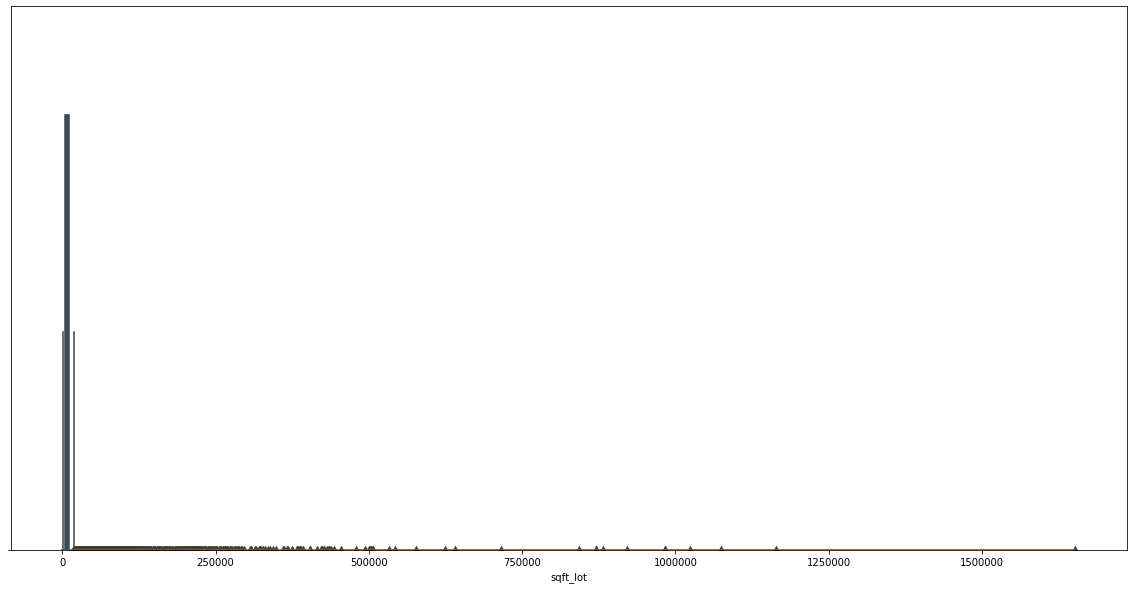

In [23]:
plt.figure(figsize=(20,10))
sns.boxplot(x='sqft_lot', data=df);
sns.distplot(df.sqft_lot);
# removed properties that have lots greater than 10000 as we are looking to live closer to the city
df = df[df.sqft_lot < 10000]
df.sqft_lot.value_counts()

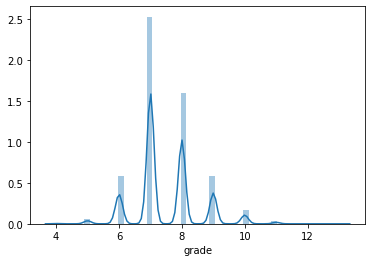

In [24]:
sns.distplot(df.grade);

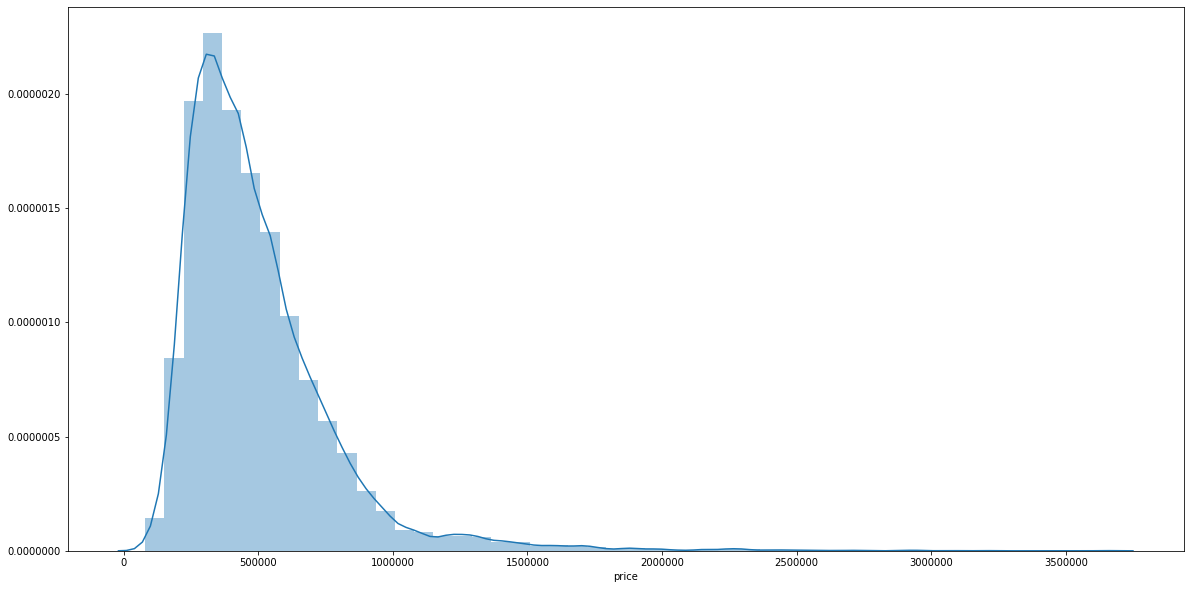

In [25]:
plt.figure(figsize=(20,10))
sns.distplot(df.price)

In [26]:
# not removing outliers of price yet to include in eda quesetions - remove for model
# df = df[df.price <= 1500000]
# sns.distplot(df.price)


In [27]:
df.price.max()

3650000.0

In [28]:
df.to_csv('../data/cleaned_data.csv')